# Group Project Proposal

Group: 83

### Title

### Introduction:
- Provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your proposal
- Clearly state the question you will try to answer with your project
- Identify and describe the dataset that will be used to answer the question

Accroding to CDC, heart disease is one of the leading cause of death around the world. The most common risk factors that cause heart disease are high blood pressure and cholesterol. That's why we have chosen these two variables as predictors for our data analysis. 

Predictive question: Can we use the blood pressure and cholestoral to predict whether a person has heart disease or not?

This dataset is from the UCI Machine Learning Repository. The repository contains four databases about heart disease from four different places: Cleveland, Budapset, California, and Zurich. We will be using the Cleveland version of the database. 

- trestbps: resting blood pressure (in mm Hg on admission to the hospital)
- chol: serum cholesterol in mg/dl


### Preliminary exploratory data analysis:
- Demonstrate that the dataset can be read from the web into R 
- Clean and wrangle your data into a tidy format
- Using only training data, summarize the data in at least one table (this is exploratory data analysis). An example of a useful table could be one that reports the number of observations in each class, the means of the predictor variables you plan to use in your analysis and how many rows have missing data. 
- Using only training data, visualize the data with at least one plot relevant to the analysis you plan to do (this is exploratory data analysis). An example of a useful visualization could be one that compares the distributions of each of the predictor variables you plan to use in your analysis.

In [12]:
library(tidyverse) #first run this to load package
library(tidymodels)

In [13]:
download.file(url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", destfile = "data/processed.cleveland.data")
data <- read_csv(file = "data/processed.cleveland.data", col_names = c("age","sex","cp","trestbps","chol","fbs","restecg","thalach","exang","oldpeak","slope","ca","thal","num_the_predicted_attribute"))

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Because it says experiments with the Cleveland database have concentrated on simply attempting to distinguish presence (values 1,2,3,4) from absence (value 0), for this project, value 1,2,3,4 have the same meaning, so I make value 2,3,4 in num_the_predicted_attribute to be value 1.

In [14]:
data1 <- filter(data, num_the_predicted_attribute <=1)
data2 <- filter(data, num_the_predicted_attribute > 1)
data2 <- mutate(data2, num_the_predicted_attribute = 1)
data <- merge(data1, data2, all = T)
data <- mutate(data, num_the_predicted_attribute = as_factor(num_the_predicted_attribute))#change num_the_predicted_attribute to be factor

In [15]:
data <- select(data, trestbps ,chol, num_the_predicted_attribute) #Select the data we need

We choose 75% as training data.

In [16]:
data_split <- initial_split(data, prop = 0.75, strata = num_the_predicted_attribute) #split training data
data_train <- training(data_split)   
data_test <- testing(data_split)

We summary data for each variable's mean.

In [17]:
summary_data <- group_by(data_train,num_the_predicted_attribute) |>
    summarize(trestbps_mean = mean(trestbps), chol_mean = mean(chol), n=n())
summary_data

num_the_predicted_attribute,trestbps_mean,chol_mean,n
<fct>,<dbl>,<dbl>,<int>
0,127.9756,241.0325,123
1,134.8846,251.7692,104


We count missing data in each column.

In [18]:
missing_data <- data_train %>%
    map_df(is.na) %>%
    map_df(sum)
missing_data

trestbps,chol,num_the_predicted_attribute
<int>,<int>,<int>
0,0,0


It looks like there is no missing data.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



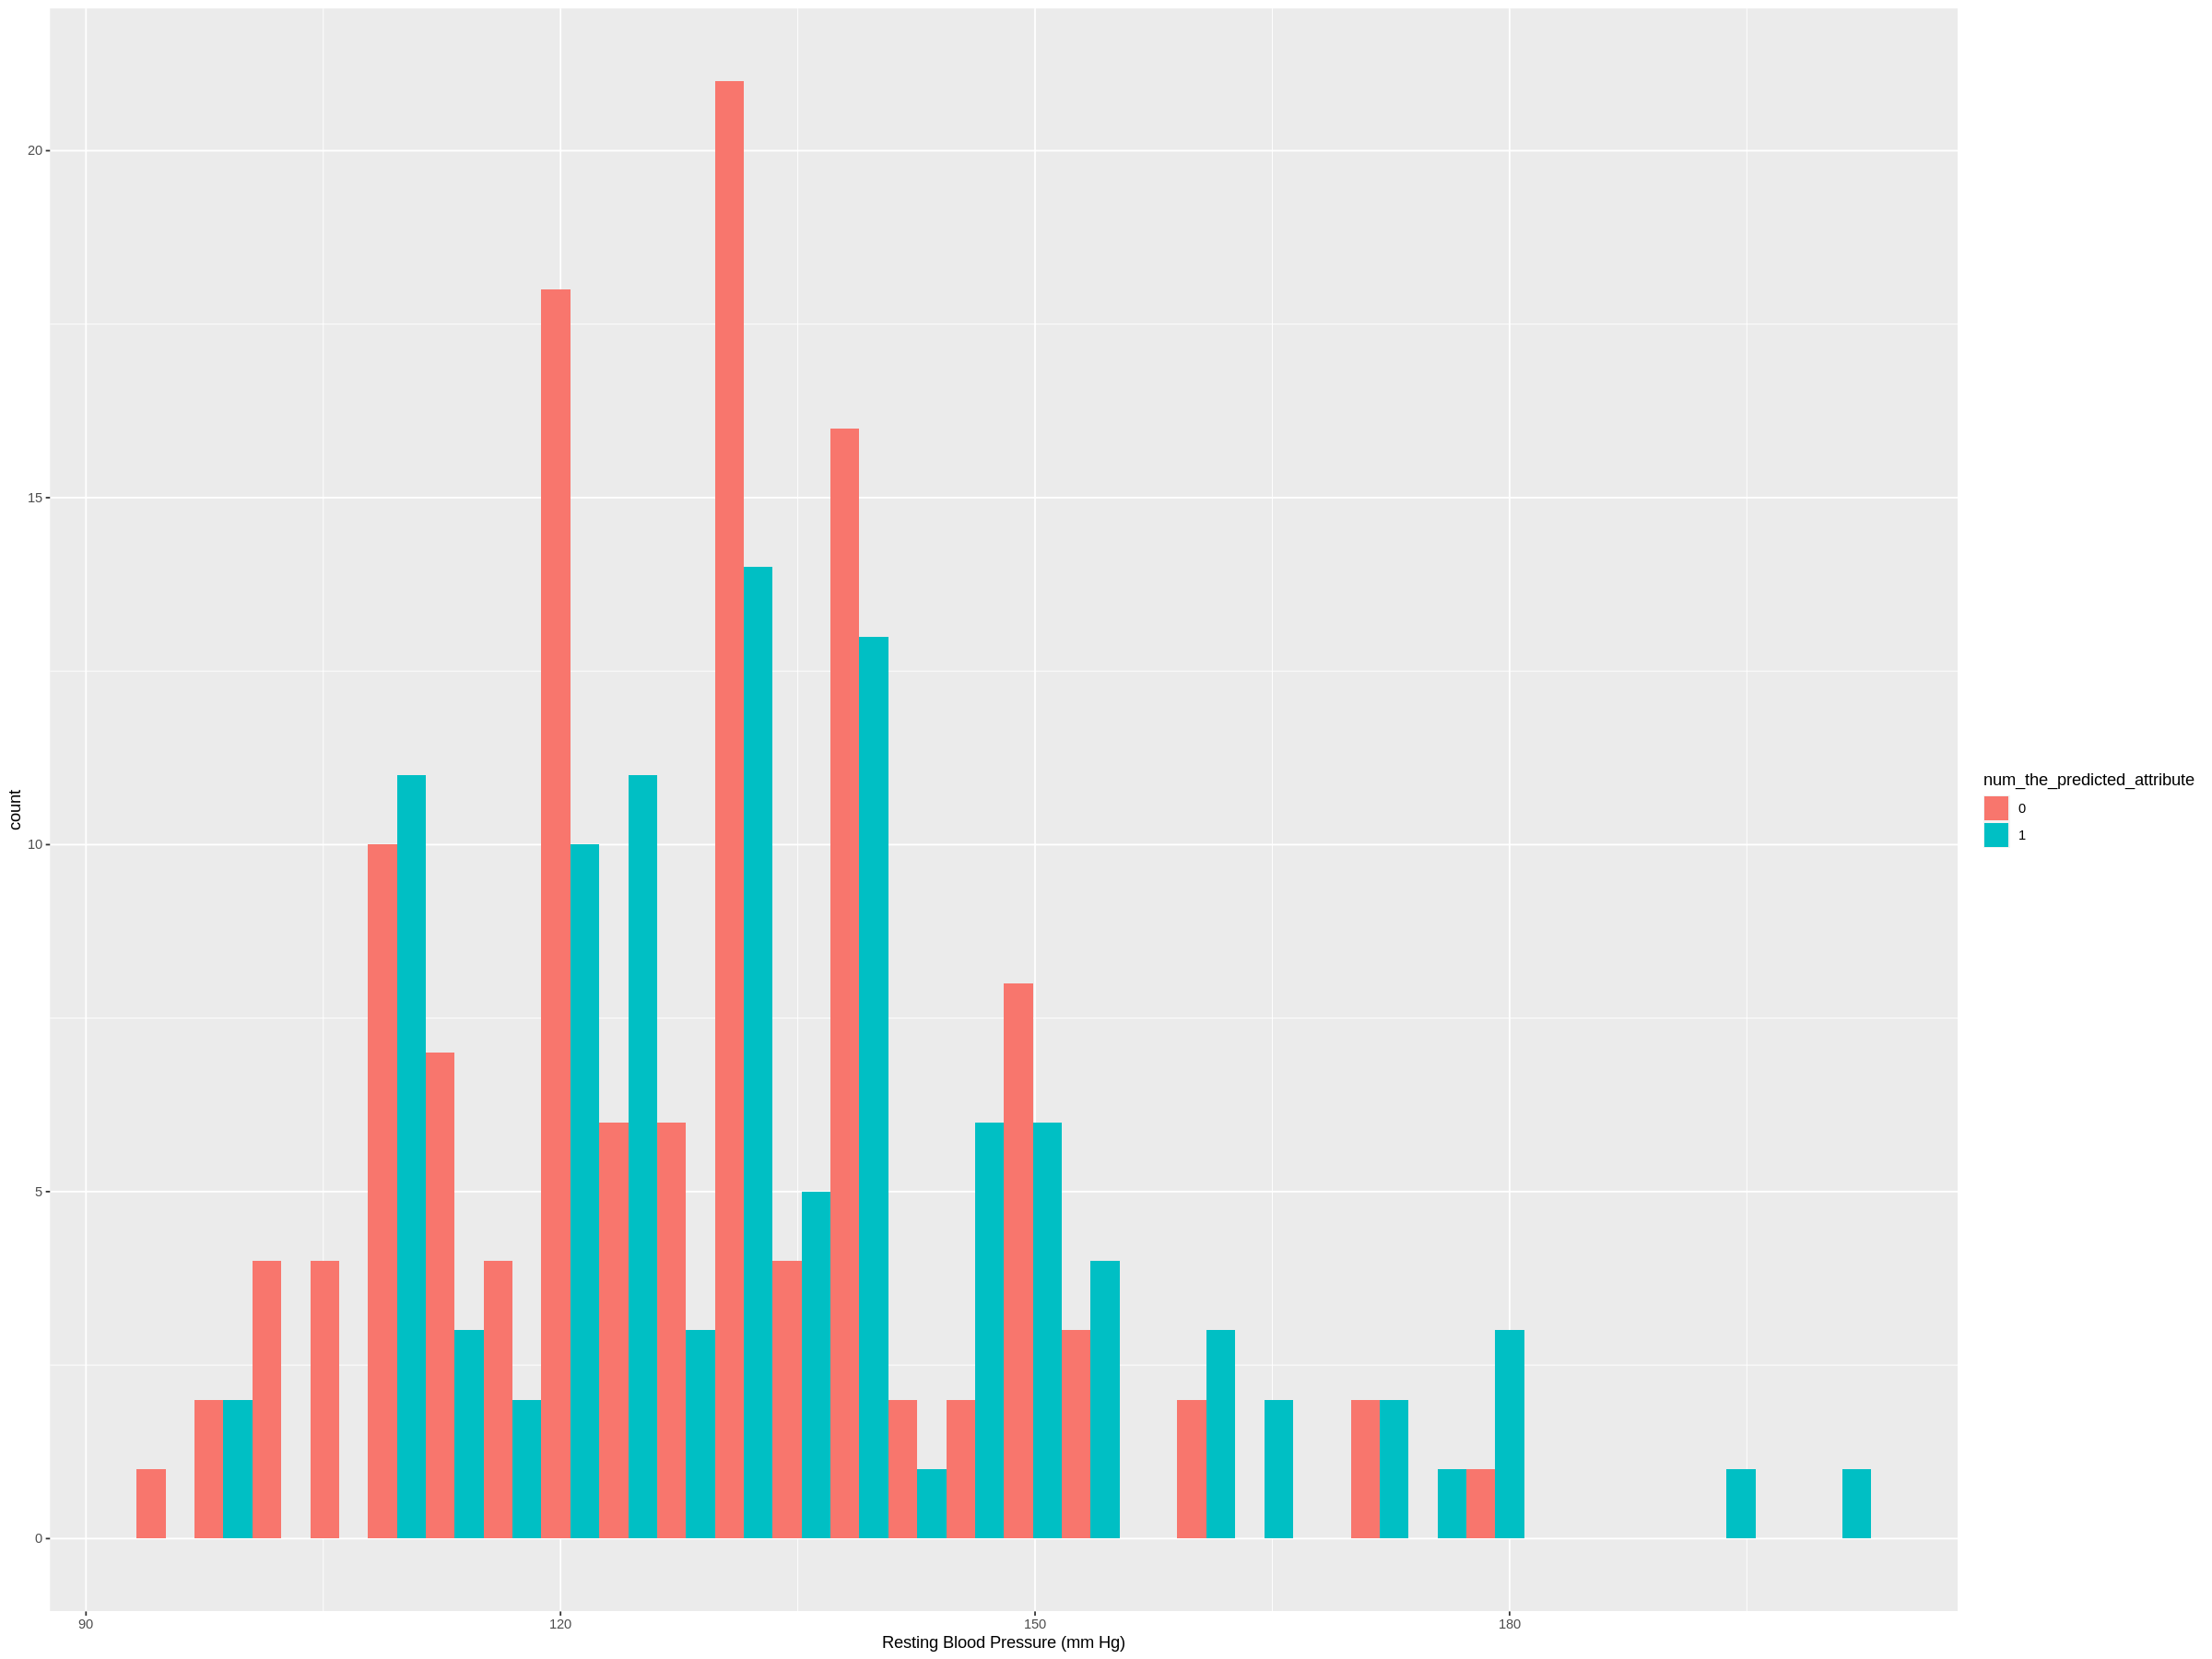

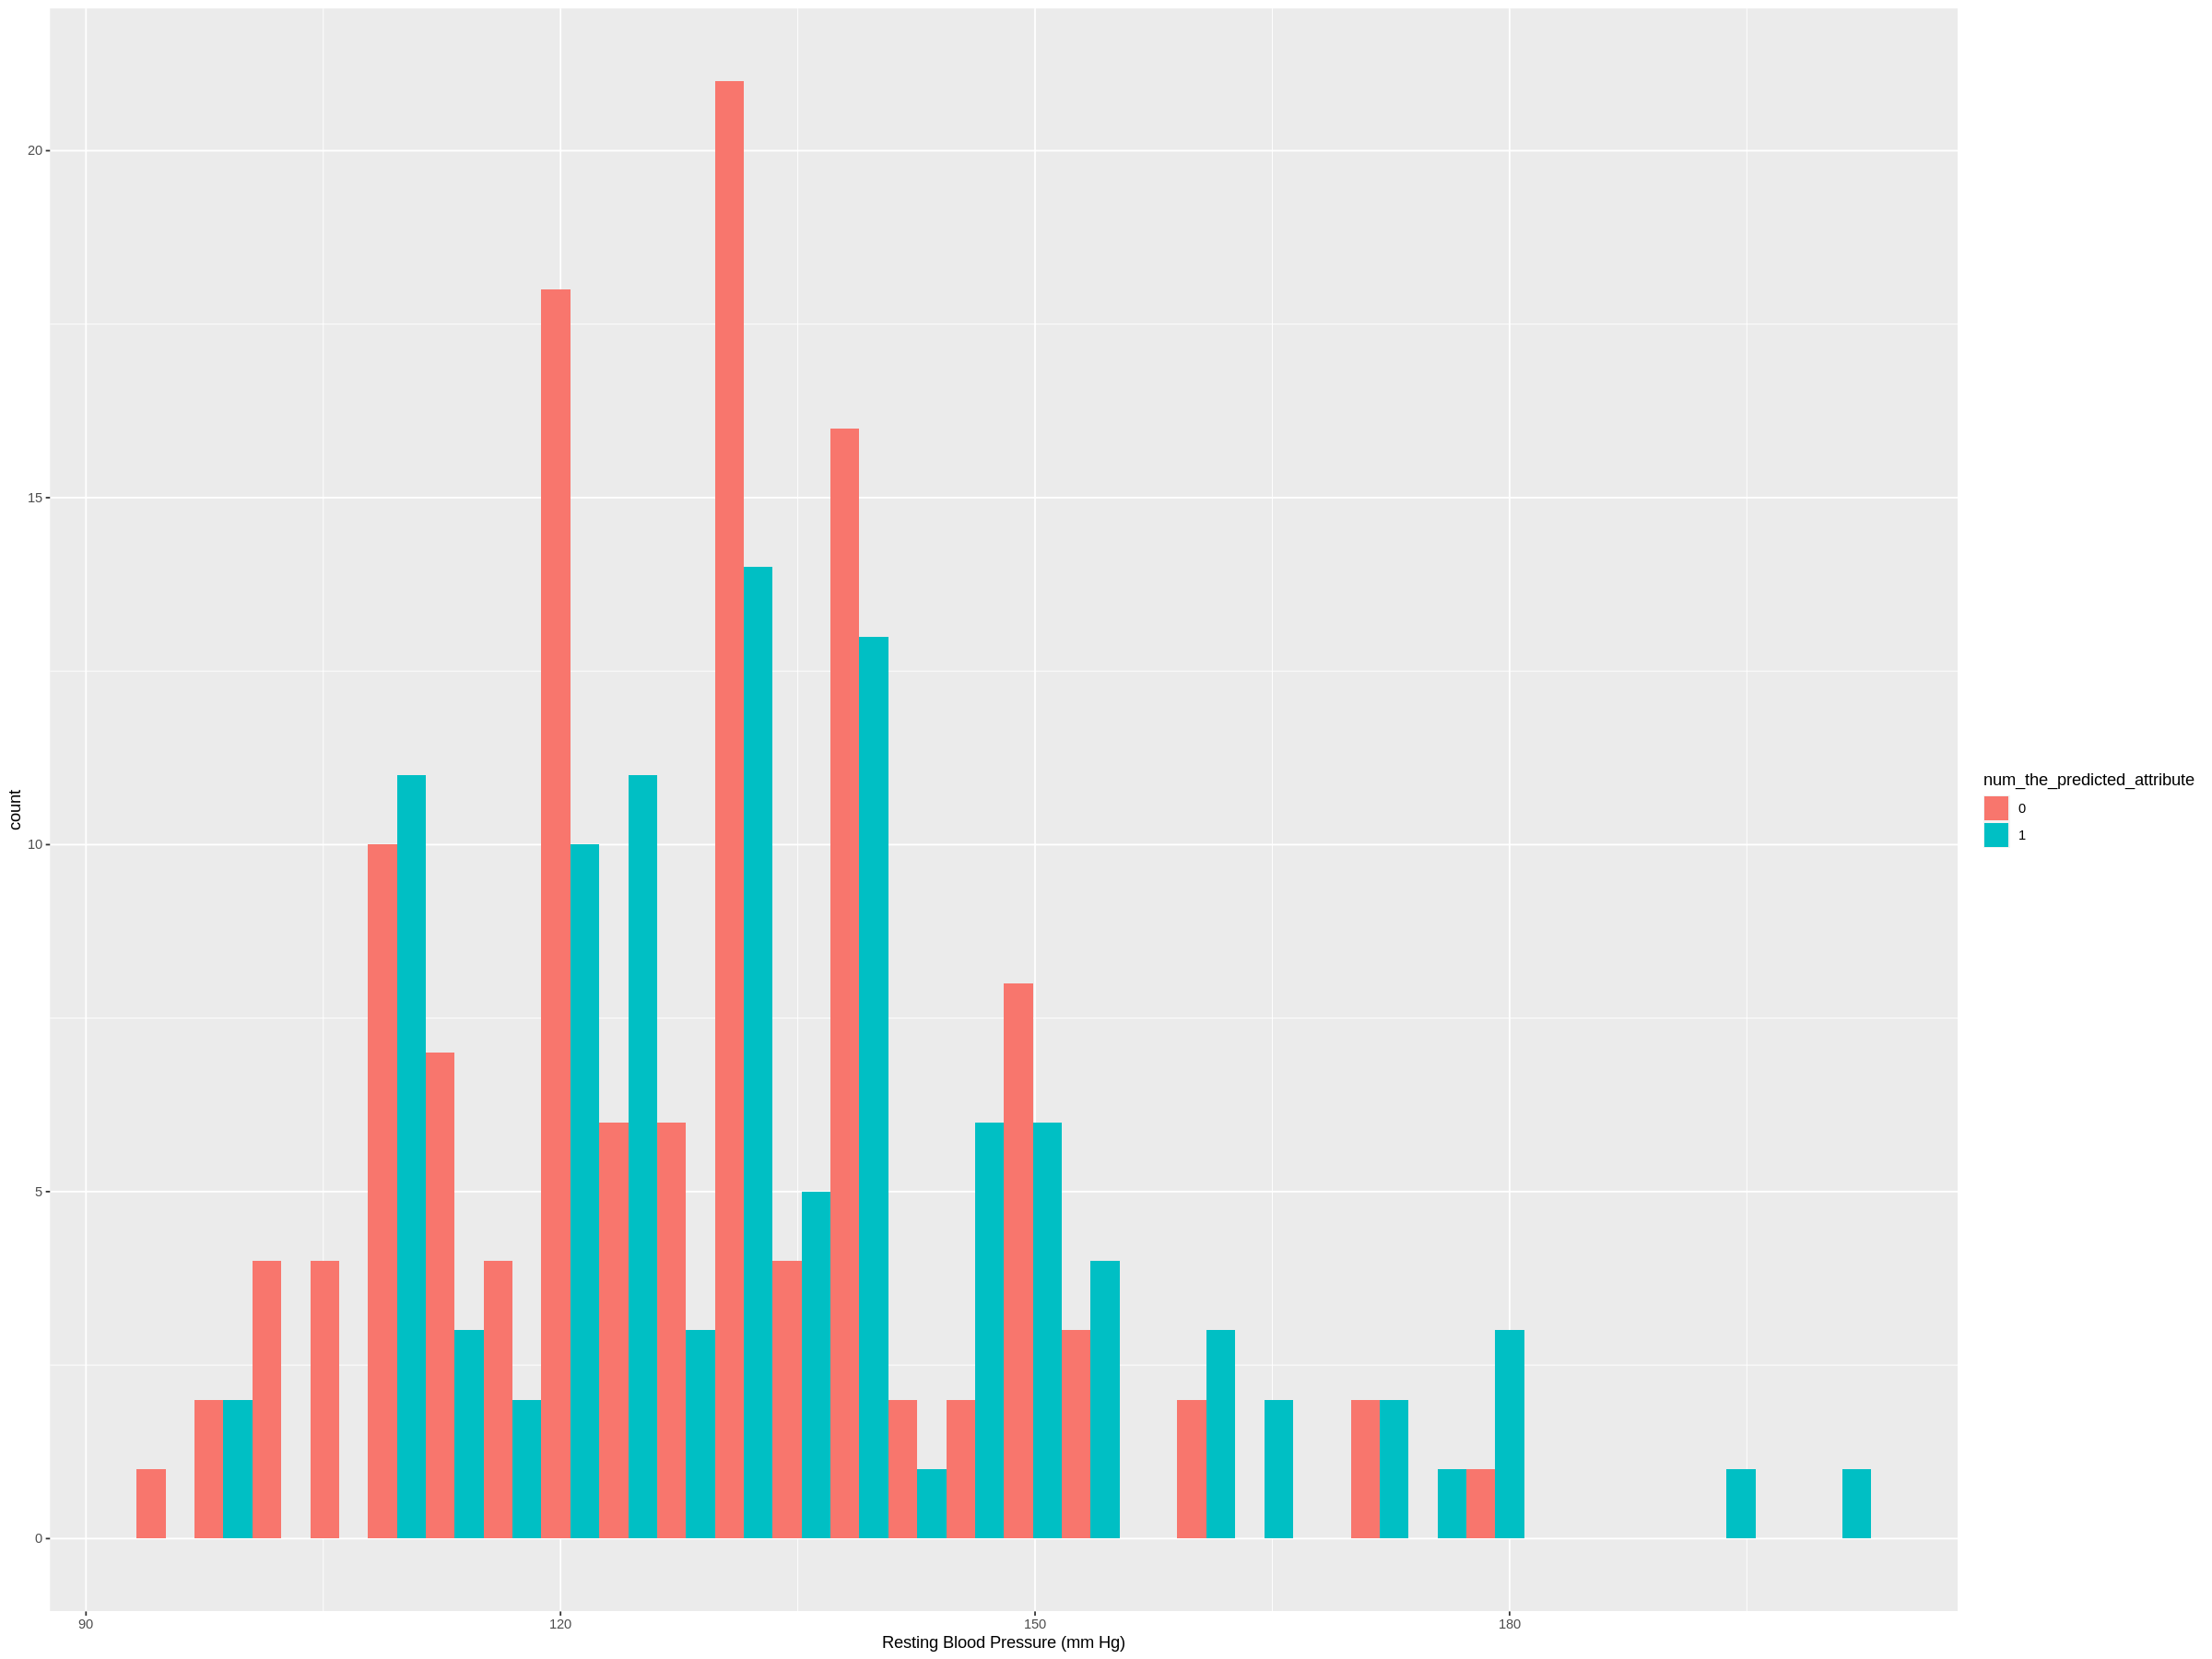

In [20]:
options(repr.plot.width = 20, repr.plot.height = 15) 
bp_plot <- ggplot(data_train, aes(x = trestbps, fill = num_the_predicted_attribute)) +
           geom_histogram(position = "dodge") +
           labs(x = "Resting Blood Pressure (mm Hg)", colour = "Predicted")          

bp_plot

chol_plot <- ggplot(data_train, aes(x = chol, fill = num_the_predicted_attribute)) +
           geom_histogram(position = "dodge") +
           labs(x = "Rchol", colour = "Predicted")          

bp_plot

### Methods:
- Explain how you will conduct either your data analysis and which variables/columns you will use. Note - you do not need to use all variables/columns that exist in the raw data set. In fact, that's often not a good idea. For each variable think: is this a useful variable for prediction?
- Describe at least one way that you will visualize the results

### Expected outcomes and significance:
- What do you expect to find?
- What impact could such findings have?
- What future questions could this lead to?